<a href="https://colab.research.google.com/github/AneleMbabela/tensorflow2-working-with-nlp/blob/main/04_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **BERT**

In [1]:
%%capture
!pip install -U tensorflow-text
!pip install tf-models-official


In [2]:
import os
import shutil
from pathlib import Path

import tensorflow as tf
import tensorflow_hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import datetime

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [8]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = Path('.') / 'aclImdb'
train_dir = Path(dataset_dir) / 'train'
test_dir = Path(dataset_dir) / 'test'

remove_dir = Path(train_dir) / 'unsup'
shutil.rmtree(remove_dir)

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 1

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)  

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Overview

*   Let's take a look at a sample. So you can see both the review text and the associated label - 0 for a negative review and 1 for a positive review.

In [11]:
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b"Poorly structured, badly written, loaded with cliches and flat dialogue. Not a single scene shines. The actors struggle with a painfully dull scenario that manages to completely avoid any surprises, plot twists or conflict. You know from the first ten minutes where it's going.<br /><br />For a movie set in NY, it has almost no feeling for the city. There are a dozen other indie movies that manage to make it seem magical on a small budget. This one seems like it was shot in Toronto.<br /><br />If you cast Natasha Henstridge, why dress her in baggy sweaters? Why make Vartan look boring and drab? Where's the attraction? I felt like I was watching a sub-par Christian movie of the week it was so asexual and moralizing.<br /><br />Steven Feder's big success is that he convinced people to make this bland movie."
Label : 0 (neg)
Review: b'this movie, i won\'t call it a "film," was basically about nothing and functioned mostly for the popular acts of the time. yeah the war was on full

**Build a bert model**

In [12]:
#tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3' # BERT model
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1' # small BERT model
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3'
bert_preprocess_model = tensorflow_hub.KerasLayer(tfhub_handle_preprocess)

sentence = ['I like nlp']
text_preprocessed = bert_preprocess_model(sentence)

print(f'Shape       : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids    : {text_preprocessed["input_word_ids"][0, : 12]}')
print(f'Input Mask  : {text_preprocessed["input_mask"][0, : 12]}')
print(f'Type Ids    : {text_preprocessed["input_type_ids"][0, : 12]}')

Shape       : (1, 128)
Word Ids    : [ 101  146 1176  183 1233 1643  102    0    0    0    0    0]
Input Mask  : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids    : [0 0 0 0 0 0 0 0 0 0 0 0]


In [13]:
bert_model = tensorflow_hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, : 12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.9999982   0.081607   -0.9971956   0.01151122 -0.9965372  -0.10179879
 -0.91629314 -0.726131    0.16070108 -0.15485592 -0.1403125  -0.09926453]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-1.247094   -0.348022   -2.8169596  ... -1.0223976  -0.5486642
   0.4155478 ]
 [-1.3511565  -1.3228742   0.63541454 ... -0.9826267  -1.5024691
   1.1037158 ]
 [-1.9130938  -0.85812074  0.33952504 ... -2.4654903  -1.1236168
   1.3087872 ]
 ...
 [-1.2427813  -1.431713    0.31718177 ... -1.5987799  -0.8911335
   0.88397235]
 [-1.0035266  -1.31159     0.27349642 ... -1.4690684  -0.95014274
   0.73115623]
 [-0.9430742  -1.1566832   0.39200246 ... -1.224145   -1.1596254
   0.5896002 ]]


**BERT classifier**

In [15]:
def bert_classifier():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = tensorflow_hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = tensorflow_hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [17]:
model = bert_classifier()
bert_raw_result = model(tf.constant(sentence))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.80655205]], shape=(1, 1), dtype=float32)


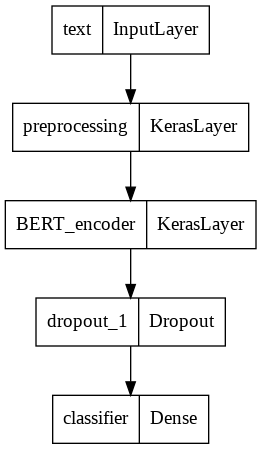

In [18]:
tf.keras.utils.plot_model(model)

In [20]:
# Loss function
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

# Optimizer
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)



*   In general callbacks and tensorboard are good tools to use for understanding, optimising and visualising model training so we will work with them here.
*   In the TensorFlow working with images course, we looked at callbacks.




In [21]:
CHECKPOINT_DIR = './BERT_training_checkpoits'
CHECKPOINT_PREFIX = Path(CHECKPOINT_DIR) / "checkpoint_{epoch}"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PREFIX,
    monitor='val_accuracy',
    mode='max')

In [22]:
MODEL_NAME = f'BERT-{datetime.datetime.now():%Y%m%d-%H%M%S}'

CHECKPOINT_DIR = './' + MODEL_NAME
CHECKPOINT_PREFIX = Path(CHECKPOINT_DIR) / "checkpoint_{epoch}"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PREFIX,
    monitor='val_accuracy',
    mode='max')

tensorboard = tf.keras.callbacks.TensorBoard(
                            log_dir=f'./tensorboardlogs/{MODEL_NAME}',
                            write_graph=True,
                            write_images=True,
                            histogram_freq=1)

In [ ]:
callbacks = [
                checkpoint,
                tensorboard
]

hist = model.fit(
              train_ds,
              epochs=epochs,
              validation_data=val_ds,
              callbacks=callbacks).history


Epoch 1/10
383/625 [=================>............] - ETA: 3:03 - loss: 0.7148 - binary_accuracy: 0.5070

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./tensorboardlogs/

In [ ]:
history_dict = hist
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

 **Make predictions**

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'Transformers have been a boon to NLP. It is going to be a case of before transformers and after transformers - they are wonderful.', 
    'From the first time I heard about them, I have found them to be dull and uninteresting.'
]

results = tf.sigmoid(model(tf.constant(examples)))

print('Results from the model in memory:')
print_my_examples(examples, results)